# WASP-80b external data modelling: constant radius ratio

Here we fit the previously published WASP-80b light curves assuming *wavelength-independent radius ratio* and *white noise*. The next step is to model the noise as a Gaussian process, and then allow for *wavelength-dependent radius ratio*.

**Note:** The number of walkers, DE iterations, and MCMC iterations (as well as MCMC thinning and burn-in) have been chosen based on many trial runs. The idea of this notebook is to *just work*.

In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
from extcore import *

In [4]:
lpf = LPFunctionCKRN()

In [5]:
npop = 150
nit  = 2500
de = DiffEvol(lpf, lpf.ps.bounds, npop, maximize=True)
sampler = EnsembleSampler(npop, lpf.ps.ndim, lpf)

pvwn = pd.read_hdf('results/external.h5', 'ckwn/mc').values
pv0  = lpf.pv_population_from_wn(pvwn)

In [12]:
nit = 50
if sampler.chain.shape[1] != 0:
    pv0 = sampler.chain[:,-1,:].copy()

for i,c in enumerate(sampler.sample(pv0, iterations=nit)):
    clear_output()
    display(sampler.iterations)

100

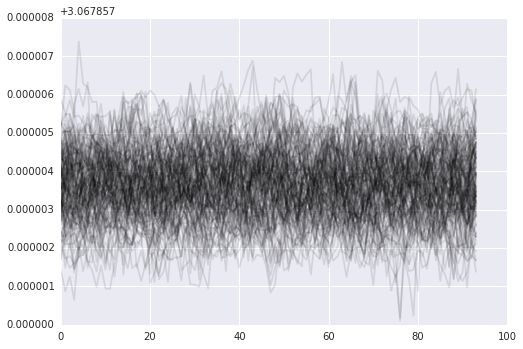

In [20]:
plot(sampler.chain[:,3000:12400:100,1].T, 'k', alpha=0.1);

In [21]:
fc = sampler.chain[:,3000:12400:100,:].reshape([-1,lpf.ps.ndim])
mp = median(fc,0)

In [22]:
dfde = pd.DataFrame(de.population, columns=lpf.ps.names)
dfmc = pd.DataFrame(sampler.chain[:,-1,:], columns=lpf.ps.names)
dffc = pd.DataFrame(fc, columns=lpf.ps.names)

In [23]:
dfde.to_hdf('results/external.h5','/ckrn/de')
dfde.to_hdf('results/external.h5','/ckrn/mc')
dffc.to_hdf('results/external.h5','/ckrn/fc')

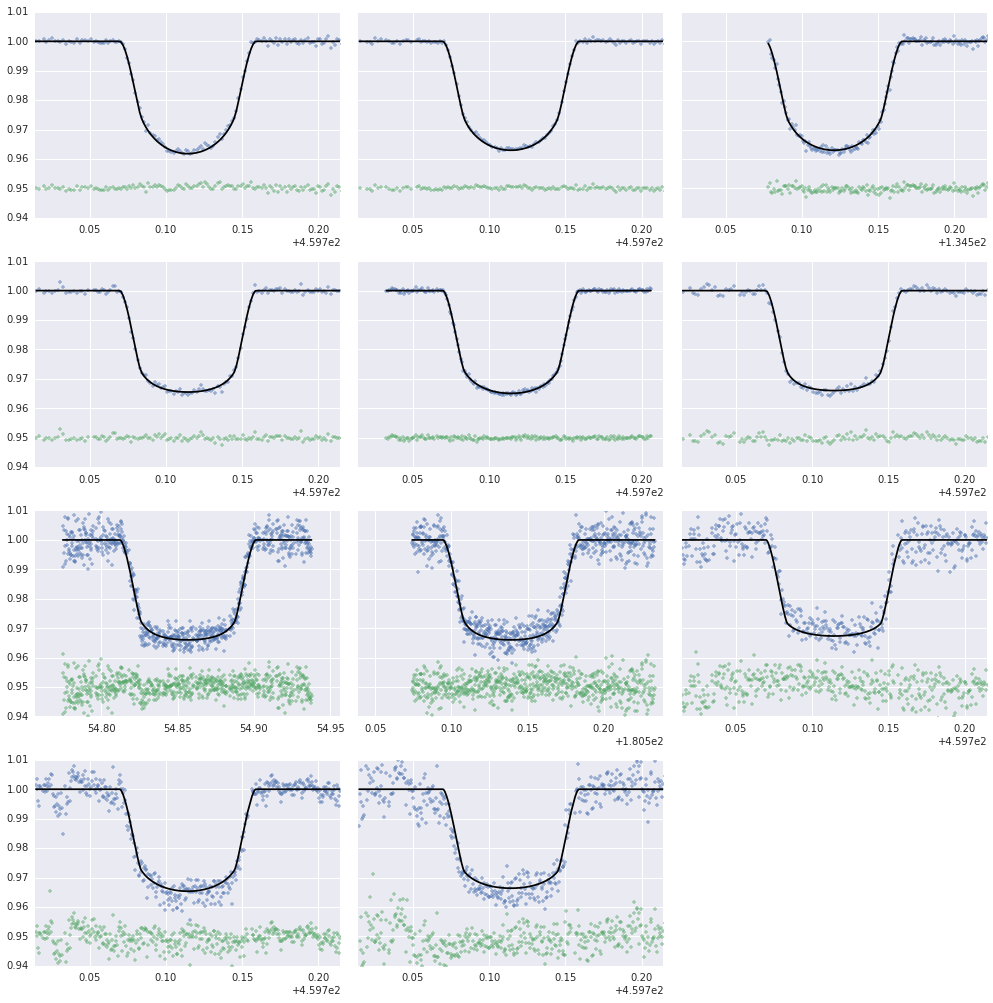

In [24]:
tn = np.round((array(map(mean, lpf.times)) - TC) / P)
xlims = [[TC+n*P-0.1, TC+n*P+0.1,] for n in tn]

flux_m = lpf.compute_transit(mp)
fig,axs = subplots(4,3, figsize=(14,14),sharey=True)
[a.plot(t,f,'.', alpha=0.5) for a,t,f in zip(axs.flat,lpf.times,lpf.fluxes)]
[a.plot(t,f,'k') for a,t,f in zip(axs.flat,lpf.times,flux_m)]
[a.plot(t,fo-fm+0.95,'.', alpha=0.5) for a,t,fo,fm in zip(axs.flat,lpf.times,lpf.fluxes,flux_m)]
[setp(a, xlim=xlim) for a,xlim in zip(axs.flat,xlims)]
setp(axs, ylim=(0.94,1.01))
fig.tight_layout()
axs.flat[-1].set_visible(False)